# Comprehensive Quantum Machine Learning Comparison with Parallel Execution

This notebook implements and compares multiple quantum machine learning models with:
- **Parallel batch execution** on CPU and GPU
- **Training progress monitoring**
- **SPSA optimizer** for noise resilience
- **Fixed qubit numbers** across all models

Models implemented:
- **VQC** (Variational Quantum Classifier)
- **QSVM** (Quantum Support Vector Machine)
- **QNN** (Quantum Neural Network)
- **QCNN** (Quantum Convolutional Neural Network)
- **QRNN** (Quantum Recurrent Neural Network)
- **QGAN** (Quantum Generative Adversarial Network)

Each model is tested on three backends:
- CPU Simulator (with parallel execution)
- GPU with cuQuantum (with parallel execution)
- IBM Quantum Hardware

## 1. Enable GPU Runtime

**Important**: Before running this notebook, ensure GPU is enabled:
1. Go to Runtime → Change runtime type
2. Select GPU as Hardware accelerator (T4 recommended)
3. Click Save

In [ ]:
# Check GPU availability and system information
import subprocess
import sys
import multiprocessing

# Check if GPU is available
try:
    gpu_info = subprocess.check_output(['nvidia-smi'], stderr=subprocess.STDOUT).decode()
    print("GPU Information:")
    print(gpu_info)
except:
    print("No GPU detected. Please enable GPU runtime in Colab.")
    print("Go to Runtime -> Change runtime type -> GPU")

# Check CPU information
print(f"\nCPU Cores: {multiprocessing.cpu_count()}")
print(f"Python Version: {sys.version}")

GPU Information:
Wed Jul 16 03:31:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+------------------------------

## 2. Install Dependencies

In [ ]:
# Install quantum computing packages
!pip install -q qiskit qiskit-machine-learning qiskit-ibm-runtime qiskit-aer

# Install GPU support for Qiskit (includes cuQuantum)
!pip install -q qiskit-aer-gpu

# Install other dependencies
!pip install -q torch torchvision scikit-learn matplotlib pylatexenc

print("Installation completed!")

# Verify installations
import qiskit
import qiskit_aer
print(f"\nQiskit version: {qiskit.__version__}")
print(f"Qiskit Aer version: {qiskit_aer.__version__}")

Installation completed!

Qiskit version: 1.4.3
Qiskit Aer version: 0.15.1


## 3. Import Libraries and Setup

In [ ]:
# Standard imports
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Optional
import json
import warnings
from datetime import datetime
from concurrent.futures import ThreadPoolExecutor, as_completed
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Qiskit imports
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import (
    RealAmplitudes, ZZFeatureMap, ZFeatureMap,
    TwoLocal, EfficientSU2, PauliFeatureMap
)
from qiskit.quantum_info import SparsePauliOp

# Qiskit Machine Learning imports
from qiskit_machine_learning.algorithms import VQC, QSVC, QSVR
from qiskit_machine_learning.neural_networks import (
    EstimatorQNN, SamplerQNN
)
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.optimizers import COBYLA, SPSA
from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_machine_learning.connectors import TorchConnector

# Simulator and Runtime imports
from qiskit_aer import AerSimulator
from qiskit.primitives import Sampler, Estimator
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, EstimatorV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Visualization
from qiskit.visualization import plot_histogram, circuit_drawer

print("All libraries imported successfully!")

# Check versions
print(f"\nQiskit version: {qiskit.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")

All libraries imported successfully!

Qiskit version: 1.4.3
PyTorch version: 2.6.0+cu124
CUDA available: True
CUDA version: 12.4
GPU device: Tesla T4


## 4. Configuration

In [ ]:
# Set random seeds for reproducibility
SEED = 1376
algorithm_globals.random_seed = SEED
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Configuration
CONFIG = {
    'feature_dim': 2,
    'num_qubits': 2,  # Fixed qubit number for all models
    'training_size': 80,
    'test_size': 20,
    'batch_size': 20,  # Batch size for parallel execution
    'max_iterations': 6,  # Reduced for testing
    'ibm_token': '',  # Add your IBM Quantum token here
    'ibm_instance' : '',# Add your IBM Quantum Instance name here
    'use_gpu': torch.cuda.is_available(),
    'backends': ['cpu', 'gpu', 'ibm_quantum_platform'],  # Available backends
    'num_parallel_jobs': 4,  # Number of parallel jobs for simulation
    'show_training_progress': True,  # Show training progress
}

print(f"Configuration:")
print(f"  GPU Available: {CONFIG['use_gpu']}")
print(f"  CUDA Version: {torch.version.cuda if CONFIG['use_gpu'] else 'N/A'}")
print(f"  Feature Dimension: {CONFIG['feature_dim']}")
print(f"  Fixed Qubit Number: {CONFIG['num_qubits']}")
print(f"  Training Size: {CONFIG['training_size']}")
print(f"  Test Size: {CONFIG['test_size']}")
print(f"  Batch Size: {CONFIG['batch_size']}")
print(f"  Max Iterations: {CONFIG['max_iterations']}")
print(f"  Parallel Jobs: {CONFIG['num_parallel_jobs']}")

Configuration:
  GPU Available: True
  CUDA Version: 12.4
  Feature Dimension: 2
  Fixed Qubit Number: 2
  Training Size: 80
  Test Size: 20
  Batch Size: 20
  Max Iterations: 10
  Parallel Jobs: 4


## 5. Data Preparation

Data prepared:
  Training samples: 80
  Test samples: 20
  Features: 2
  Classes: 2


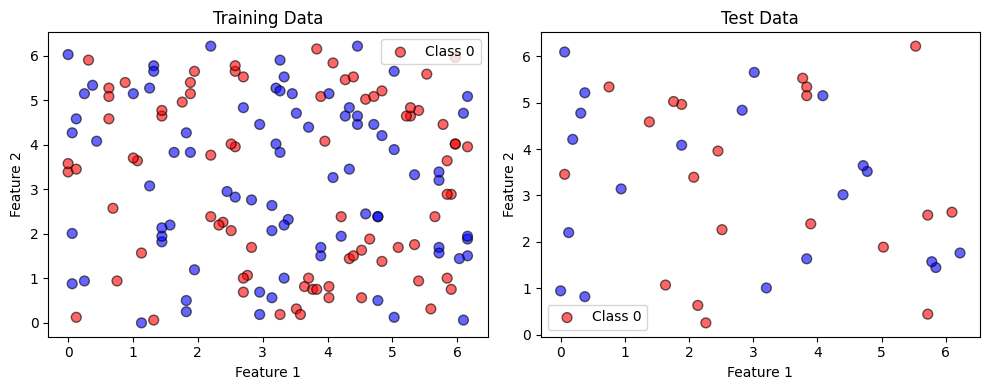

In [ ]:
def prepare_data():
    """Prepare quantum dataset for classification"""
    # Load ad-hoc quantum dataset
    training_features, training_labels, test_features, test_labels = ad_hoc_data(
        training_size=CONFIG['training_size'],
        test_size=CONFIG['test_size'],
        n=CONFIG['feature_dim'],
        gap=0.3
    )

    # Convert one-hot labels to integer labels
    train_labels_int = np.argmax(training_labels, axis=1)
    test_labels_int = np.argmax(test_labels, axis=1)
    num_classes = training_labels.shape[1]

    return {
        'train_features': training_features,
        'train_labels': training_labels,
        'train_labels_int': train_labels_int,
        'test_features': test_features,
        'test_labels': test_labels,
        'test_labels_int': test_labels_int,
        'num_classes': num_classes
    }

# Prepare data
data = prepare_data()
print(f"Data prepared:")
print(f"  Training samples: {CONFIG['training_size']}")
print(f"  Test samples: {CONFIG['test_size']}")
print(f"  Features: {CONFIG['feature_dim']}")
print(f"  Classes: {data['num_classes']}")

# Visualize data distribution
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
colors = ['red' if label == 0 else 'blue' for label in data['train_labels_int']]
plt.scatter(data['train_features'][:, 0], data['train_features'][:, 1],
            c=colors, alpha=0.6, edgecolor='k', s=50)
plt.title('Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(['Class 0', 'Class 1'])

plt.subplot(1, 2, 2)
colors = ['red' if label == 0 else 'blue' for label in data['test_labels_int']]
plt.scatter(data['test_features'][:, 0], data['test_features'][:, 1],
            c=colors, alpha=0.6, edgecolor='k', s=50)
plt.title('Test Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(['Class 0', 'Class 1'])

plt.tight_layout()
plt.show()

## 6. Backend Setup Functions with Parallel Support

In [ ]:
QiskitRuntimeService.save_account(
    channel='ibm_quantum_platform',
    token=CONFIG['ibm_token'],
    instance=CONFIG['ibm_instance'] ,
    overwrite=True
)

# 接続確認
service = QiskitRuntimeService()
backends = service.backends()
print(f"Available backends: {[b.name for b in backends]}")

Available backends: ['ibm_brisbane', 'ibm_sherbrooke', 'ibm_torino']


In [ ]:
def get_cpu_backend():
    """Get CPU simulator backend with parallel configuration"""
    backend = AerSimulator(
        method='statevector',
        device='CPU',
        max_parallel_threads=CONFIG['num_parallel_jobs'],
        max_parallel_experiments=CONFIG['num_parallel_jobs'],
        batched_shots_gpu=False,
        blocking_enable=True,
        blocking_qubits=14
    )
    print(f"CPU backend initialized with {CONFIG['num_parallel_jobs']} parallel jobs")
    return backend

def get_gpu_backend():
    """Get GPU-accelerated backend with cuQuantum support"""
    if not CONFIG['use_gpu']:
        print("GPU not available, falling back to CPU simulator")
        return get_cpu_backend()

    try:
        # Try to use cuQuantum-enabled backend with parallel GPU execution
        backend = AerSimulator(
            method='statevector',
            device='GPU',
            cuStateVec_enable=True,
            batched_shots_gpu=True,
            batched_shots_gpu_max_qubits=16,
            blocking_enable=True,
            blocking_qubits=14
        )
        print("cuQuantum GPU backend initialized successfully with parallel support")
        return backend
    except Exception as e:
        print(f"cuQuantum initialization failed: {e}")
        # Fallback to regular GPU backend
        try:
            backend = AerSimulator(
                method='statevector',
                device='GPU',
                batched_shots_gpu=True
            )
            print("Regular GPU backend initialized with parallel support")
            return backend
        except:
            print("GPU backend failed, falling back to CPU")
            return get_cpu_backend()

def get_ibm_backend(service=None):
    """Get IBM Quantum backend with new platform configuration"""
    if not CONFIG['ibm_token']:
        print("IBM token not provided, using simulator")
        return None, None

    try:
        if service is None:
            # Use the new ibm_quantum_platform channel
            service = QiskitRuntimeService(
                channel='ibm_quantum_platform',  # Updated channel
                token=CONFIG['ibm_token'],
                # Optional: specify region preference
                region='us-east',  # or 'eu-de'
                # Optional: specify plan preference
                plans_preference=['Open', 'Standard']
            )

            # Save account for future use (optional)
            # QiskitRuntimeService.save_account(
            #     channel='ibm_quantum_platform',
            #     token=CONFIG['ibm_token'],
            #     overwrite=True
            # )

        # Get available backends
        backends = service.backends()
        print(f"Available backends: {[b.name for b in backends]}")

        # Get least busy backend
        backend = service.least_busy(simulator=False, operational=True)
        print(f"IBM Quantum Backend: {backend}")
        print(f"  Status: {backend.status()}")
        print(f"  Queue: {backend.status().pending_jobs}")

        return backend, service
    except Exception as e:
        print(f"IBM backend setup failed: {e}")
        # Try with explicit instance if available
        if CONFIG.get('ibm_instance'):
            try:
                service = QiskitRuntimeService(
                    channel='ibm_quantum_platform',
                    token=CONFIG['ibm_token'],
                    instance=CONFIG['ibm_instance']  # e.g., 'ibm-q/open/main'
                )
                backend = service.least_busy(simulator=False, operational=True)
                print(f"IBM Quantum Backend (with instance): {backend}")
                return backend, service
            except Exception as e2:
                print(f"IBM backend setup with instance also failed: {e2}")

        return None, None

# Test backend setup
print("Testing backend setup...")
print("\nCPU backend:")
cpu_backend = get_cpu_backend()
print(f"  {cpu_backend}")

print("\nGPU backend:")
gpu_backend = get_gpu_backend()
print(f"  {gpu_backend}")

Testing backend setup...

CPU backend:
CPU backend initialized with 4 parallel jobs
  AerSimulator('aer_simulator_statevector')

GPU backend:
cuQuantum GPU backend initialized successfully with parallel support
  AerSimulator('aer_simulator_statevector_gpu')


## 7. Training Progress Callback

In [ ]:
class TrainingProgressCallback:
    """Callback class for monitoring training progress"""

    def __init__(self, model_name, backend_type):
        self.model_name = model_name
        self.backend_type = backend_type
        self.iteration = 0
        self.losses = []
        self.start_time = time.time()

    def __call__(self, *args):
        """Callback function for optimizer - handles variable arguments"""
        self.iteration += 1

        # Extract loss value from arguments
        # SPSA passes (nfev, params, fval, stepsize, accepted)
        # VQC callback passes different arguments
        fk = None
        if len(args) >= 3:
            # Try to extract loss value
            if isinstance(args[2], (int, float)):
                fk = float(args[2])
            elif len(args) > 0 and isinstance(args[0], (int, float)):
                fk = float(args[0])

        if fk is not None:
            self.losses.append(fk)

        if CONFIG['show_training_progress'] and self.iteration % 5 == 0:
            elapsed_time = time.time() - self.start_time
            loss_str = f"{fk:.4f}" if fk is not None else "N/A"
            print(f"[{self.model_name}@{self.backend_type}] Iteration {self.iteration}: "
                  f"Loss = {loss_str}, Time = {elapsed_time:.2f}s")

# Test callback
test_callback = TrainingProgressCallback('Test', 'cpu')
print("Training progress callback initialized")

Training progress callback initialized


## 8. Quantum Models Implementation with Parallel Execution

In [ ]:
class QuantumModels:
    """Collection of quantum machine learning models with parallel execution support"""

    def __init__(self, data, backend_type='cpu'):
        self.data = data
        self.backend_type = backend_type
        self.results = {}
        self._setup_backend()

    def _setup_backend(self):
        """Setup the appropriate backend"""
        if self.backend_type == 'cpu':
            self.backend = get_cpu_backend()
            self.sampler = AerSampler(backend_options={
                "max_parallel_threads": CONFIG['num_parallel_jobs'],
                "max_parallel_experiments": CONFIG['num_parallel_jobs']
            })
            self.estimator = AerEstimator(backend_options={
                "max_parallel_threads": CONFIG['num_parallel_jobs'],
                "max_parallel_experiments": CONFIG['num_parallel_jobs']
            })
        elif self.backend_type == 'gpu':
            self.backend = get_gpu_backend()
            self.sampler = AerSampler(backend_options={
                "device": "GPU",
                "batched_shots_gpu": True
            })
            self.estimator = AerEstimator(backend_options={
                "device": "GPU",
                "batched_shots_gpu": True
            })
        elif self.backend_type == 'ibm_quantum_platform':
            self.backend, self.service = get_ibm_backend()
            if self.backend:
                self.sampler = SamplerV2(mode=self.backend)
                self.estimator = EstimatorV2(mode=self.backend)
                self.pass_manager = generate_preset_pass_manager(backend=self.backend)
            else:
                # Fallback to CPU
                #self.backend_type = 'cpu'
                #self._setup_backend()
                print("Error:IBM Quantum Real Device Backend")

    def _create_batches(self, features, labels):
        """Create batches for parallel processing"""
        n_samples = features.shape[0]
        batch_size = CONFIG['batch_size']
        batches = []

        for i in range(0, n_samples, batch_size):
            end = min(i + batch_size, n_samples)
            batches.append({
                'features': features[i:end],
                'labels': labels[i:end],
                'indices': list(range(i, end))
            })

        return batches

# Create model instance
print("Creating QuantumModels instance...")
qml = QuantumModels(data, backend_type='cpu')
print("Instance created successfully!")

Creating QuantumModels instance...
CPU backend initialized with 4 parallel jobs
Instance created successfully!


### 8.1 VQC Implementation with Parallel Execution

In [ ]:
# Add VQC method to QuantumModels class
def train_vqc(self):
    """Train Variational Quantum Classifier with parallel execution"""
    print(f"\n=== Training VQC on {self.backend_type} ===")

    # Define feature map and ansatz with fixed qubit number
    feature_map = ZZFeatureMap(
        feature_dimension=CONFIG['feature_dim'],
        reps=2,
        entanglement="linear"
    )
    ansatz = RealAmplitudes(
        num_qubits=CONFIG['num_qubits'],
        reps=3
    )

    # Create callback for progress monitoring
    callback = TrainingProgressCallback('VQC', self.backend_type)

    # Create VQC with SPSA optimizer for noise resilience
    vqc_kwargs = {
        'feature_map': feature_map,
        'ansatz': ansatz,
        'optimizer': SPSA(
            maxiter=CONFIG['max_iterations'],
            callback=callback
        ),
        'sampler': self.sampler,
        'callback': callback
    }

    if self.backend_type == 'ibm_quantum_platform':
        vqc_kwargs['pass_manager'] = self.pass_manager

    vqc = VQC(**vqc_kwargs)

    # Train with batch processing
    start_time = time.time()

    if self.backend_type in ['cpu', 'gpu']:
        # Parallel batch training for simulators
        batches = self._create_batches(
            self.data['train_features'],
            self.data['train_labels']
        )
        print(f"Training with {len(batches)} batches of size {CONFIG['batch_size']}")

        # Train on batches
        for i, batch in enumerate(batches):
            print(f"Processing batch {i+1}/{len(batches)}")
            vqc.fit(batch['features'], batch['labels'])
    else:
        # Regular training for IBM Quantum
        vqc.fit(self.data['train_features'], self.data['train_labels'])

    train_time = time.time() - start_time

    # Evaluate
    accuracy = vqc.score(self.data['test_features'], self.data['test_labels'])

    self.results['VQC'] = {
        'accuracy': accuracy,
        'train_time': train_time,
        'backend': self.backend_type,
        'iterations': callback.iteration,
        'losses': callback.losses
    }

    print(f"VQC Accuracy: {accuracy:.3f}, Time: {train_time:.2f}s")

    # Visualize circuit
    qc = QuantumCircuit(CONFIG['num_qubits'])
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    print("\nVQC Circuit:")
    display(qc.decompose().draw('mpl', scale=0.7))

    return vqc

# Add method to class
QuantumModels.train_vqc = train_vqc

# Test VQC
#vqc_model = qml.train_vqc()

### 8.2 QSVM Implementation with Parallel Kernel Computation

In [ ]:
# Add QSVM method to QuantumModels class
def train_qsvm(self):
    """Train Quantum Support Vector Machine with parallel kernel computation"""
    print(f"\n=== Training QSVM on {self.backend_type} ===")

    # Define feature map with fixed qubit number
    feature_map = ZFeatureMap(
        feature_dimension=CONFIG['feature_dim'],
        reps=2
    )

    # Ensure we're using the correct number of qubits
    if feature_map.num_qubits != CONFIG['num_qubits']:
        # Pad or adjust feature map if needed
        feature_map = ZZFeatureMap(
            feature_dimension=CONFIG['num_qubits'],
            reps=2
        )

    # Create quantum kernel with batch evaluation
    if self.backend_type == 'ibm_quantum_platform':
        quantum_kernel = FidelityQuantumKernel(
            feature_map=feature_map,
            pass_manager=self.pass_manager
        )
    else:
        quantum_kernel = FidelityQuantumKernel(
            feature_map=feature_map,
            evaluate_duplicates='off_diagonal'  # Optimize kernel computation
        )

    # Create QSVC
    qsvc = QSVC(quantum_kernel=quantum_kernel)

    # Create progress callback
    callback = TrainingProgressCallback('QSVM', self.backend_type)

    # Train with timing
    start_time = time.time()

    # For simulators, we can use subset for faster training
    if self.backend_type in ['cpu', 'gpu'] and CONFIG['training_size'] > 100:
        # Use subset for kernel training to speed up
        subset_size = min(100, CONFIG['training_size'])
        train_features_subset, _, train_labels_subset, _ = train_test_split(
          self.data['train_features'],
          self.data['train_labels_int'],
          train_size=subset_size,
          stratify=self.data['train_labels_int'],  # クラスの比率を維持
          random_state=SEED
        )
        # Verify we have both classes
        unique_classes = np.unique(train_labels_subset)
        if len(unique_classes) < 2:
            print(f"Warning: Subset has only {len(unique_classes)} class(es). Using full dataset.")
            train_features_subset = self.data['train_features']
            train_labels_subset = self.data['train_labels_int']
        else:
            print(f"Training QSVM with subset of {subset_size} samples")
            print(f"Class distribution: {np.bincount(train_labels_subset)}")
        print(f"Training QSVM with subset of {subset_size} samples")
        qsvc.fit(train_features_subset, train_labels_subset)
    else:
        qsvc.fit(self.data['train_features'], self.data['train_labels_int'])

    train_time = time.time() - start_time

    # Evaluate
    predictions = qsvc.predict(self.data['test_features'])
    accuracy = np.mean(predictions == self.data['test_labels_int'])

    self.results['QSVM'] = {
        'accuracy': accuracy,
        'train_time': train_time,
        'backend': self.backend_type
    }

    print(f"QSVM Accuracy: {accuracy:.3f}, Time: {train_time:.2f}s")
    return qsvc

# Add method to class
QuantumModels.train_qsvm = train_qsvm

# Test QSVM
#qsvm_model = qml.train_qsvm()

### 8.3 QNN Implementation with SPSA

In [ ]:
# Add QNN method to QuantumModels class
def train_qnn(self):
    """Train Quantum Neural Network with SPSA optimizer"""
    print(f"\n=== Training QNN on {self.backend_type} ===")

    # Create feature map and ansatz with fixed qubit number
    feature_map = ZZFeatureMap(CONFIG['num_qubits'])
    ansatz = RealAmplitudes(CONFIG['num_qubits'], reps=3)

    # Combine into a single circuit
    qc = QuantumCircuit(CONFIG['num_qubits'])
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # Create observable for measurement
    observable = SparsePauliOp.from_list([("Z" * CONFIG['num_qubits'], 1)])

    # Create QNN
    qnn = EstimatorQNN(
        circuit=qc,
        observables=observable,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        estimator=self.estimator
    )

    # Create callback
    callback = TrainingProgressCallback('QNN', self.backend_type)

    # Create classifier with SPSA
    classifier = NeuralNetworkClassifier(
        qnn,
        optimizer=SPSA(
            maxiter=CONFIG['max_iterations'],
            callback=callback
        ),
        callback=callback
    )

    # Prepare data - pad if necessary
    train_features = self.data['train_features']
    test_features = self.data['test_features']

    if CONFIG['num_qubits'] > CONFIG['feature_dim']:
        # Pad features to match qubit count
        pad_width = CONFIG['num_qubits'] - CONFIG['feature_dim']
        train_features = np.pad(train_features, ((0, 0), (0, pad_width)), 'constant')
        test_features = np.pad(test_features, ((0, 0), (0, pad_width)), 'constant')

    # Train
    start_time = time.time()
    classifier.fit(train_features, self.data['train_labels_int'])
    train_time = time.time() - start_time

    # Evaluate
    accuracy = classifier.score(test_features, self.data['test_labels_int'])

    self.results['QNN'] = {
        'accuracy': accuracy,
        'train_time': train_time,
        'backend': self.backend_type,
        'iterations': callback.iteration,
        'losses': callback.losses
    }

    print(f"QNN Accuracy: {accuracy:.3f}, Time: {train_time:.2f}s")
    return classifier

# Add method to class
QuantumModels.train_qnn = train_qnn

# Test QNN
#qnn_model = qml.train_qnn()

### 8.4 QCNN Implementation with Fixed Qubits

In [ ]:
# Add QCNN method to QuantumModels class
def train_qcnn(self):
    """Train Quantum Convolutional Neural Network"""
    print(f"\n=== Training QCNN on {self.backend_type} ===")

    # Use fixed number of qubits
    num_qubits = max(4, CONFIG['num_qubits'])  # QCNN needs at least 4 qubits

    # Create convolutional layer
    def conv_layer(circuit, qubits):
        """Apply convolutional layer"""
        params = []
        for i in range(len(qubits) - 1):
            p1 = Parameter(f'conv_rz_{i}')
            p2 = Parameter(f'conv_ry_{i}')
            p3 = Parameter(f'conv_rz2_{i}')
            circuit.rz(p1, qubits[i])
            circuit.ry(p2, qubits[i])
            circuit.cx(qubits[i], qubits[i + 1])
            circuit.rz(p3, qubits[i + 1])
            params.extend([p1, p2, p3])
        return params

    # Create pooling layer
    def pooling_layer(circuit, qubits):
        """Apply pooling layer"""
        params = []
        for i in range(0, len(qubits), 2):
            p = Parameter(f'pool_ry_{i}')
            circuit.ry(p, qubits[i])
            params.append(p)
        return params

    # Build QCNN circuit
    qcnn = QuantumCircuit(num_qubits)
    all_params = []

    # Feature encoding
    feature_params = ParameterVector('x', num_qubits)
    for i in range(num_qubits):
        qcnn.ry(feature_params[i], i)

    # Convolutional and pooling layers
    conv_params = conv_layer(qcnn, list(range(num_qubits)))
    pool_params = pooling_layer(qcnn, list(range(num_qubits)))
    all_params.extend(conv_params + pool_params)

    # Final layer
    final_params = [Parameter('final_ry'), Parameter('final_rz')]
    qcnn.ry(final_params[0], 0)
    qcnn.rz(final_params[1], 0)
    all_params.extend(final_params)

    # Create QNN with QCNN circuit
    observable = SparsePauliOp.from_list([("Z" + "I" * (num_qubits - 1), 1)])

    # Prepare padded features
    def pad_features(features):
        """Pad features to match qubit count"""
        if features.shape[1] < num_qubits:
            padded = np.zeros((features.shape[0], num_qubits))
            padded[:, :features.shape[1]] = features
            return padded
        return features[:, :num_qubits]

    train_features_padded = pad_features(self.data['train_features'])
    test_features_padded = pad_features(self.data['test_features'])

    # Create QNN
    qnn = EstimatorQNN(
        circuit=qcnn,
        observables=observable,
        input_params=feature_params,
        weight_params=all_params,
        estimator=self.estimator
    )

    # Create callback
    callback = TrainingProgressCallback('QCNN', self.backend_type)

    # Create and train classifier with SPSA
    classifier = NeuralNetworkClassifier(
        qnn,
        optimizer=SPSA(
            maxiter=CONFIG['max_iterations'] // 2,
            callback=callback
        ),
        callback=callback
    )

    start_time = time.time()
    classifier.fit(train_features_padded, self.data['train_labels_int'])
    train_time = time.time() - start_time

    # Evaluate
    accuracy = classifier.score(test_features_padded, self.data['test_labels_int'])

    self.results['QCNN'] = {
        'accuracy': accuracy,
        'train_time': train_time,
        'backend': self.backend_type,
        'iterations': callback.iteration,
        'losses': callback.losses
    }

    print(f"QCNN Accuracy: {accuracy:.3f}, Time: {train_time:.2f}s")

    # Visualize QCNN circuit
    print("\nQCNN Circuit:")
    display(qcnn.decompose().draw('mpl', scale=0.6))

    return classifier

# Add method to class
QuantumModels.train_qcnn = train_qcnn

# Test QCNN
#qcnn_model = qml.train_qcnn()

### 8.5 QRNN Implementation with Fixed Qubits

In [ ]:
# Add QRNN method to QuantumModels class
def train_qrnn(self):
    """Train Quantum Recurrent Neural Network"""
    print(f"\n=== Training QRNN on {self.backend_type} ===")

    try:
        # Create a parameterized circuit that acts as RNN cell
        def create_qrnn_cell():
            """Create a quantum RNN cell"""
            # Use CONFIG['num_qubits'] + 1 for hidden state
            total_qubits = CONFIG['num_qubits'] + 1
            qc = QuantumCircuit(total_qubits)

            # Input parameters
            input_params = ParameterVector('input', CONFIG['num_qubits'])
            hidden_param = Parameter('hidden')

            # Encode input
            for i in range(CONFIG['num_qubits']):
                qc.ry(input_params[i], i)

            # Encode hidden state
            qc.ry(hidden_param, CONFIG['num_qubits'])

            # Entangling layer
            for i in range(CONFIG['num_qubits']):
                qc.cx(i, CONFIG['num_qubits'])

            # Variational layer
            var_params = ParameterVector('var', 2 * total_qubits)
            for i in range(total_qubits):
                qc.ry(var_params[i], i)
                qc.rz(var_params[i + total_qubits], i)

            return qc, input_params, hidden_param, var_params

        # Create QRNN cell
        qc, input_params, hidden_param, var_params = create_qrnn_cell()

        # Observable
        observable = SparsePauliOp.from_list([("Z" + "I" * CONFIG['num_qubits'], 1)])

        # Create QNN
        all_input_params = list(input_params) + [hidden_param]
        qnn = EstimatorQNN(
            circuit=qc,
            observables=observable,
            input_params=all_input_params,
            weight_params=var_params,
            estimator=self.estimator
        )

        # Prepare data with hidden state
        def prepare_rnn_data(features):
            """Add hidden state dimension to features"""
            # Pad features if necessary
            if features.shape[1] < CONFIG['num_qubits']:
                padded = np.zeros((features.shape[0], CONFIG['num_qubits']))
                padded[:, :features.shape[1]] = features
                features = padded
            else:
                features = features[:, :CONFIG['num_qubits']]

            # Add hidden state
            hidden_states = np.zeros((features.shape[0], 1))
            return np.hstack([features, hidden_states])

        train_rnn_features = prepare_rnn_data(self.data['train_features'])
        test_rnn_features = prepare_rnn_data(self.data['test_features'])

        # Create callback
        callback = TrainingProgressCallback('QRNN', self.backend_type)

        # Create and train classifier with SPSA
        classifier = NeuralNetworkClassifier(
            qnn,
            optimizer=SPSA(
                maxiter=CONFIG['max_iterations'] // 2,
                callback=callback
            ),
            callback=callback
        )

        start_time = time.time()
        classifier.fit(train_rnn_features, self.data['train_labels_int'])
        train_time = time.time() - start_time

        # Evaluate
        accuracy = classifier.score(test_rnn_features, self.data['test_labels_int'])

        self.results['QRNN'] = {
            'accuracy': accuracy,
            'train_time': train_time,
            'backend': self.backend_type,
            'iterations': callback.iteration,
            'losses': callback.losses
        }

        print(f"QRNN Accuracy: {accuracy:.3f}, Time: {train_time:.2f}s")

        # Visualize circuit
        print("\nQRNN Cell Circuit:")
        display(qc.decompose().draw('mpl', scale=0.7))

        return classifier

    except Exception as e:
        print(f"Error in QRNN training: {e}")
        self.results['QRNN'] = {
            'error': str(e),
            'backend': self.backend_type
        }
        return None

# Add method to class
QuantumModels.train_qrnn = train_qrnn

# Test QRNN
#qrnn_model = qml.train_qrnn()

### 8.6 QGAN Implementation

In [ ]:
# Add QGAN method to QuantumModels class
def train_qgan(self):
    """Train Quantum Generative Adversarial Network"""
    print(f"\n=== Training QGAN on {self.backend_type} ===")

    # QGAN requires PyTorch integration
    if self.backend_type == 'ibm_quantum_platform':
        print("QGAN training on IBM Quantum is not recommended due to high circuit evaluations")
        return None

    try:
        # Generator circuit with fixed qubits
        num_qubits = max(3, CONFIG['num_qubits'])
        generator = QuantumCircuit(num_qubits)

        # Random input (latent space)
        latent_params = ParameterVector('latent', num_qubits)
        for i in range(num_qubits):
            generator.ry(latent_params[i], i)

        # Generator ansatz
        gen_ansatz = EfficientSU2(num_qubits, reps=2)
        generator.compose(gen_ansatz, inplace=True)

        # Create generator QNN
        gen_qnn = SamplerQNN(
            circuit=generator,
            input_params=latent_params,
            weight_params=gen_ansatz.parameters,
            sampler=self.sampler
        )

        # Discriminator circuit (classical for stability)
        class Discriminator(nn.Module):
            def __init__(self, input_dim):
                super().__init__()
                self.model = nn.Sequential(
                    nn.Linear(input_dim, 20),
                    nn.LeakyReLU(0.2),
                    nn.Linear(20, 20),
                    nn.LeakyReLU(0.2),
                    nn.Linear(20, 1),
                    nn.Sigmoid()
                )

            def forward(self, x):
                return self.model(x)

        # Convert generator to PyTorch
        gen_torch = TorchConnector(gen_qnn)

        # Training setup
        discriminator = Discriminator(2**num_qubits)

        # Move to GPU if available and using GPU backend
        if self.backend_type == 'gpu' and torch.cuda.is_available():
            discriminator = discriminator.cuda()

        # Optimizers
        gen_optimizer = optim.Adam(gen_torch.parameters(), lr=0.01)
        disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.01)

        # Loss function
        criterion = nn.BCELoss()

        # Training parameters
        num_epochs = 20
        batch_size = CONFIG['batch_size']

        # Progress tracking
        callback = TrainingProgressCallback('QGAN', self.backend_type)

        start_time = time.time()
        losses = {'gen': [], 'disc': []}

        for epoch in range(num_epochs):
            # Generate random latent vectors
            latent_vectors = np.random.uniform(-np.pi, np.pi, (batch_size, num_qubits))

            # Generate fake data
            fake_data = gen_torch(torch.tensor(latent_vectors, dtype=torch.float32))

            # For demo, we'll use random real data
            real_data = torch.tensor(
                np.random.choice([1, 0], size=(batch_size, 2**num_qubits)),
                dtype=torch.float32
            )

            # Move to GPU if needed
            if self.backend_type == 'gpu' and torch.cuda.is_available():
                fake_data = fake_data.cuda()
                real_data = real_data.cuda()

            # Train discriminator
            disc_optimizer.zero_grad()
            real_labels = torch.ones((batch_size, 1))
            fake_labels = torch.zeros((batch_size, 1))

            if self.backend_type == 'gpu' and torch.cuda.is_available():
                real_labels = real_labels.cuda()
                fake_labels = fake_labels.cuda()

            real_loss = criterion(discriminator(real_data), real_labels)
            fake_loss = criterion(discriminator(fake_data.detach()), fake_labels)
            disc_loss = real_loss + fake_loss
            disc_loss.backward()
            disc_optimizer.step()

            # Train generator
            gen_optimizer.zero_grad()
            gen_loss = criterion(discriminator(fake_data), real_labels)
            gen_loss.backward()
            gen_optimizer.step()

            losses['gen'].append(gen_loss.item())
            losses['disc'].append(disc_loss.item())

            # Progress update
            if CONFIG['show_training_progress'] and epoch % 5 == 0:
                elapsed = time.time() - start_time
                print(f"[QGAN@{self.backend_type}] Epoch {epoch}: "
                      f"Gen Loss = {gen_loss.item():.4f}, "
                      f"Disc Loss = {disc_loss.item():.4f}, "
                      f"Time = {elapsed:.2f}s")

        train_time = time.time() - start_time

        # Final metric
        final_metric = gen_loss.item()

        self.results['QGAN'] = {
            'final_loss': final_metric,
            'train_time': train_time,
            'backend': self.backend_type,
            'gen_losses': losses['gen'],
            'disc_losses': losses['disc']
        }

        print(f"QGAN Final Loss: {final_metric:.4f}, Time: {train_time:.2f}s")

        # Plot training progress
        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(losses['gen'], label='Generator Loss')
        plt.plot(losses['disc'], label='Discriminator Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('QGAN Training Progress')
        plt.legend()


        plt.tight_layout()
        plt.show()

        return gen_torch, discriminator

    except Exception as e:
        print(f"Error in QGAN training: {e}")
        self.results['QGAN'] = {
            'error': str(e),
            'backend': self.backend_type
        }
        return None

# Add method to class
QuantumModels.train_qgan = train_qgan

# Test QGAN
#qgan_model = qml.train_qgan()

## 9. Run All Models on All Backends

In [ ]:
# Add run_all_models method
def run_all_models(self):
    """Run all quantum ML models"""
    models = {
        'VQC': self.train_vqc,
        'QSVM': self.train_qsvm,
        'QNN': self.train_qnn,
        'QCNN': self.train_qcnn,
        'QRNN': self.train_qrnn,
        'QGAN': self.train_qgan
    }

    for name, train_func in models.items():
        try:
            train_func()
        except Exception as e:
            print(f"Error training {name}: {e}")
            self.results[name] = {
                'error': str(e),
                'backend': self.backend_type
            }

    return self.results

# Add method to class
QuantumModels.run_all_models = run_all_models

Start time: 2025-07-16 03:31:46


Testing on CPU backend
CPU backend initialized with 4 parallel jobs

=== Training VQC on cpu ===
Training with 8 batches of size 20
Processing batch 1/8
[VQC@cpu] Iteration 5: Loss = 1.1143, Time = 6.43s
[VQC@cpu] Iteration 10: Loss = 0.7669, Time = 7.47s
Processing batch 2/8
[VQC@cpu] Iteration 15: Loss = 0.6886, Time = 12.66s
[VQC@cpu] Iteration 20: Loss = 0.6433, Time = 13.73s
Processing batch 3/8
[VQC@cpu] Iteration 25: Loss = 0.6124, Time = 19.63s
[VQC@cpu] Iteration 30: Loss = 0.5606, Time = 20.82s
Processing batch 4/8
[VQC@cpu] Iteration 35: Loss = 0.6790, Time = 23.84s
[VQC@cpu] Iteration 40: Loss = 0.5412, Time = 24.31s
Processing batch 5/8
[VQC@cpu] Iteration 45: Loss = 1.0041, Time = 26.39s
[VQC@cpu] Iteration 50: Loss = 0.5484, Time = 26.86s
Processing batch 6/8
[VQC@cpu] Iteration 55: Loss = 0.5447, Time = 28.92s
[VQC@cpu] Iteration 60: Loss = 0.3997, Time = 29.40s
Processing batch 7/8
[VQC@cpu] Iteration 65: Loss = 0.5291, Time = 32.63s
[

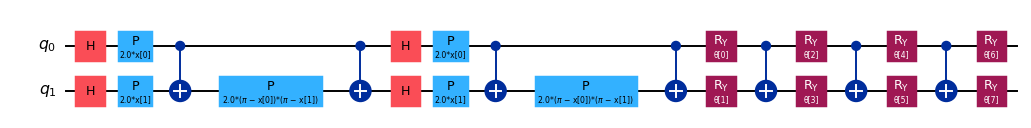


=== Training QSVM on cpu ===
QSVM Accuracy: 0.850, Time: 17.27s

=== Training QNN on cpu ===
[QNN@cpu] Iteration 5: Loss = 0.9089, Time = 20.53s
[QNN@cpu] Iteration 10: Loss = 0.5962, Time = 24.72s
QNN Accuracy: 0.400, Time: 24.72s

=== Training QCNN on cpu ===
[QCNN@cpu] Iteration 5: Loss = 0.4986, Time = 19.77s
QCNN Accuracy: 0.375, Time: 19.77s

QCNN Circuit:


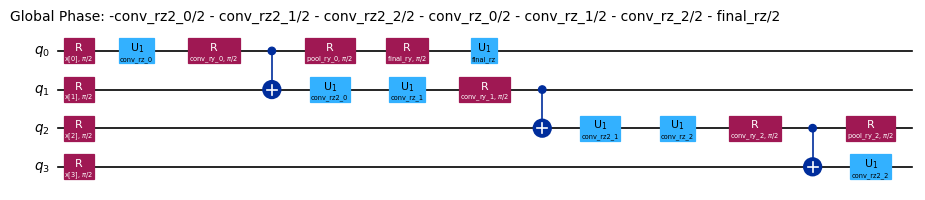


=== Training QRNN on cpu ===
[QRNN@cpu] Iteration 5: Loss = 0.5010, Time = 18.59s
QRNN Accuracy: 0.200, Time: 18.59s

QRNN Cell Circuit:


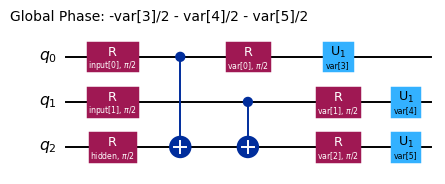


=== Training QGAN on cpu ===
[QGAN@cpu] Epoch 0: Gen Loss = 0.6452, Disc Loss = 1.3976, Time = 1.39s
[QGAN@cpu] Epoch 5: Gen Loss = 0.6584, Disc Loss = 1.2778, Time = 9.08s
[QGAN@cpu] Epoch 10: Gen Loss = 0.6722, Disc Loss = 1.1098, Time = 15.19s
[QGAN@cpu] Epoch 15: Gen Loss = 0.7902, Disc Loss = 0.8591, Time = 22.19s
QGAN Final Loss: 0.9795, Time: 27.27s


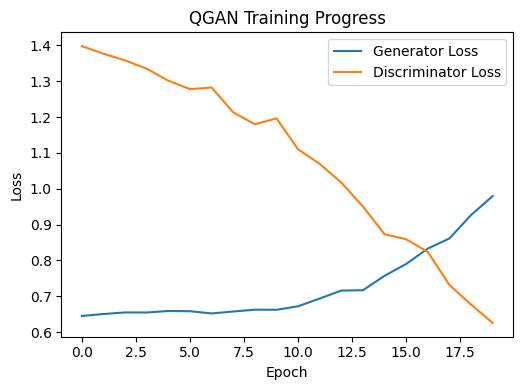


Testing on GPU backend
cuQuantum GPU backend initialized successfully with parallel support

=== Training VQC on gpu ===
Training with 8 batches of size 20
Processing batch 1/8
[VQC@gpu] Iteration 5: Loss = 0.5778, Time = 3.55s
[VQC@gpu] Iteration 10: Loss = 0.5408, Time = 4.11s
Processing batch 2/8
[VQC@gpu] Iteration 15: Loss = 0.6610, Time = 6.46s
[VQC@gpu] Iteration 20: Loss = 0.6172, Time = 7.00s
Processing batch 3/8
[VQC@gpu] Iteration 25: Loss = 0.8917, Time = 9.33s
[VQC@gpu] Iteration 30: Loss = 0.6968, Time = 9.89s
Processing batch 4/8
[VQC@gpu] Iteration 35: Loss = 0.6211, Time = 12.25s
[VQC@gpu] Iteration 40: Loss = 0.5474, Time = 13.19s
Processing batch 5/8
[VQC@gpu] Iteration 45: Loss = 0.4692, Time = 16.19s
[VQC@gpu] Iteration 50: Loss = 0.4559, Time = 16.75s
Processing batch 6/8
[VQC@gpu] Iteration 55: Loss = 0.4245, Time = 19.07s
[VQC@gpu] Iteration 60: Loss = 0.4240, Time = 19.63s
Processing batch 7/8
[VQC@gpu] Iteration 65: Loss = 0.6827, Time = 21.97s
[VQC@gpu] Iter

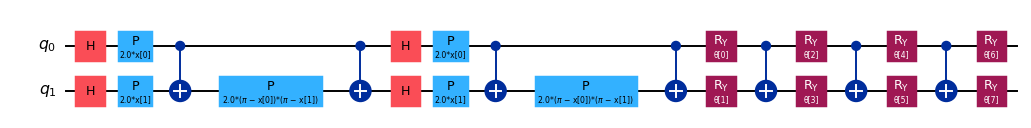


=== Training QSVM on gpu ===
QSVM Accuracy: 0.850, Time: 17.54s

=== Training QNN on gpu ===
[QNN@gpu] Iteration 5: Loss = 0.3615, Time = 24.61s
[QNN@gpu] Iteration 10: Loss = 0.3245, Time = 29.59s
QNN Accuracy: 0.425, Time: 29.59s

=== Training QCNN on gpu ===
[QCNN@gpu] Iteration 5: Loss = 0.4983, Time = 22.11s
QCNN Accuracy: 0.350, Time: 22.11s

QCNN Circuit:


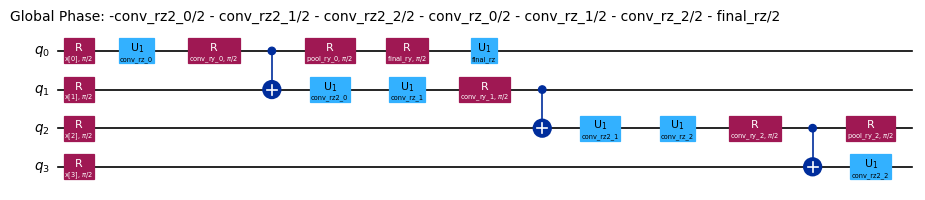


=== Training QRNN on gpu ===
[QRNN@gpu] Iteration 5: Loss = 0.5017, Time = 20.98s
QRNN Accuracy: 0.325, Time: 20.98s

QRNN Cell Circuit:


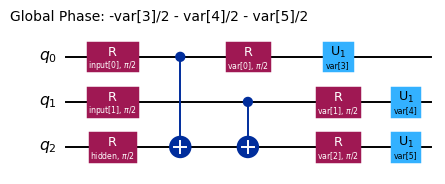


=== Training QGAN on gpu ===
[QGAN@gpu] Epoch 0: Gen Loss = 0.6822, Disc Loss = 1.4158, Time = 1.82s
[QGAN@gpu] Epoch 5: Gen Loss = 0.7665, Disc Loss = 1.2480, Time = 10.69s
[QGAN@gpu] Epoch 10: Gen Loss = 0.9131, Disc Loss = 1.0019, Time = 17.99s
[QGAN@gpu] Epoch 15: Gen Loss = 1.2615, Disc Loss = 0.5929, Time = 26.51s
QGAN Final Loss: 1.7259, Time: 32.32s


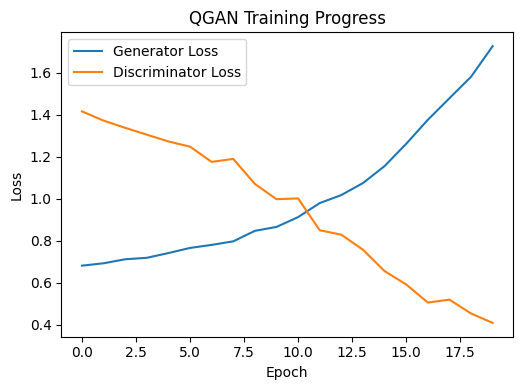


Testing on IBM_QUANTUM_PLATFORM backend


qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-07-16 03:37:01,763: Default instance not set. Searching all available instances.


Available backends: ['ibm_brisbane', 'ibm_sherbrooke', 'ibm_torino']
IBM Quantum Backend: <IBMBackend('ibm_torino')>
  Status: <qiskit_ibm_runtime.models.backend_status.BackendStatus object at 0x7970e41ad810>
  Queue: 96

=== Training VQC on ibm_quantum_platform ===


Error training VQC: "Sampler job failed: 'Unable to retrieve result for job d1riavls0e1s73bm9jtg. Job was cancelled.'"

=== Training QSVM on ibm_quantum_platform ===
Error training QSVM: FidelityQuantumKernel.__init__() got an unexpected keyword argument 'pass_manager'

=== Training QNN on ibm_quantum_platform ===
Error training QNN: 'The instruction ZZFeatureMap on qubits (0, 1) is not supported by the target system. Circuits that do not match the target hardware definition are no longer supported after March 4, 2024. See the transpilation documentation (https://quantum.cloud.ibm.com/docs/guides/transpile) for instructions to transform circuits and the primitive examples (https://quantum.cloud.ibm.com/docs/guides/primitives-examples) to see this coupled with operator transformations.'

=== Training QCNN on ibm_quantum_platform ===
Error training QCNN: 'The instruction ry on qubits (0,) is not supported by the target system. Circuits that do not match the target hardware definition are

In [ ]:
# Run comparison across different backends
all_results = {}
backends_to_test = ['cpu', 'gpu']

# Add IBM backend if token is provided
if CONFIG['ibm_token']:
    backends_to_test.append('ibm_quantum_platform')
else:
    print("IBM Quantum token not provided, skipping IBM backend\n")

print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

for backend in backends_to_test:
    print(f"\n{'='*60}")
    print(f"Testing on {backend.upper()} backend")
    print(f"{'='*60}")

    try:
        qml = QuantumModels(data, backend_type=backend)
        results = qml.run_all_models()
        all_results[backend] = results
    except Exception as e:
        print(f"Error with {backend} backend: {e}")
        all_results[backend] = {'error': str(e)}

## 10. Results Visualization and Summary

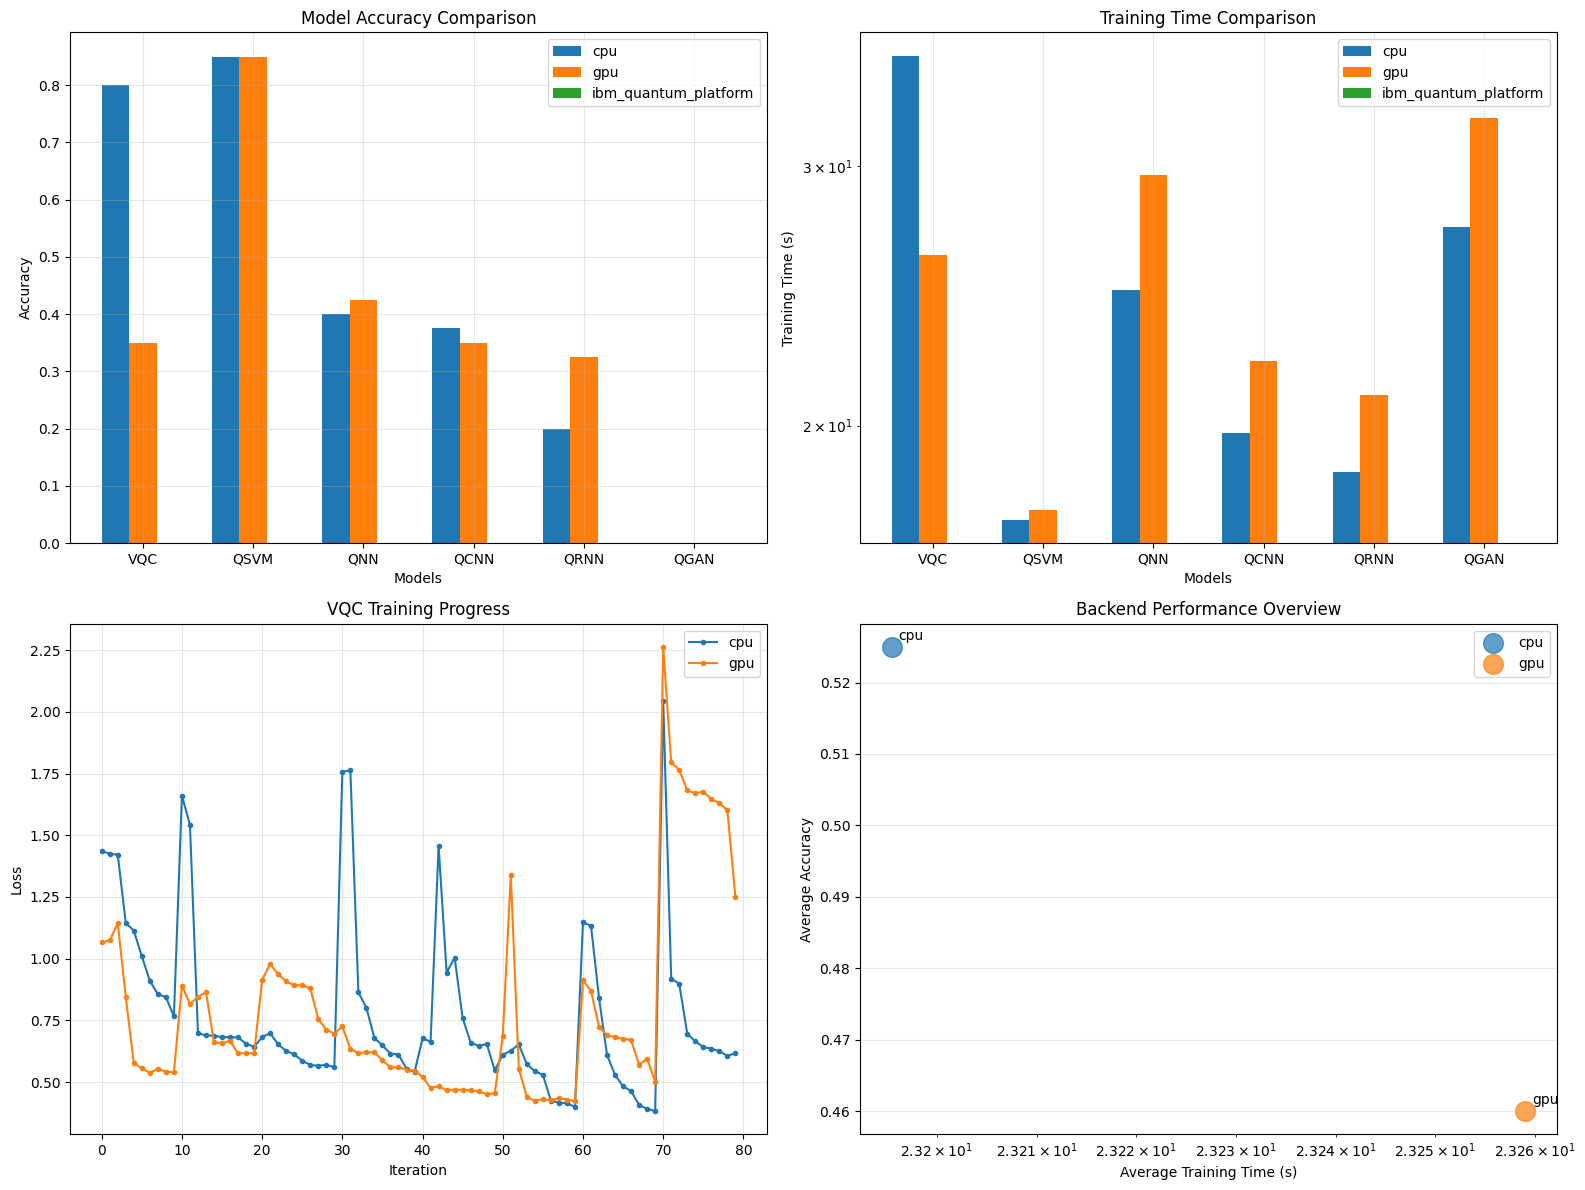

In [ ]:
def plot_results(all_results):
    """Plot comparison of results across backends and models"""
    # Prepare data for plotting
    models = ['VQC', 'QSVM', 'QNN', 'QCNN', 'QRNN', 'QGAN']
    backends = list(all_results.keys())

    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Accuracy comparison
    ax1 = axes[0, 0]
    x = np.arange(len(models))
    width = 0.25

    for i, backend in enumerate(backends):
        accuracies = []
        for model in models:
            if model in all_results[backend] and 'accuracy' in all_results[backend][model]:
                accuracies.append(all_results[backend][model]['accuracy'])
            else:
                accuracies.append(0)

        ax1.bar(x + i * width, accuracies, width, label=backend)

    ax1.set_xlabel('Models')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(models)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Training time comparison
    ax2 = axes[0, 1]
    for i, backend in enumerate(backends):
        times = []
        for model in models:
            if model in all_results[backend] and 'train_time' in all_results[backend][model]:
                times.append(all_results[backend][model]['train_time'])
            else:
                times.append(0)

        ax2.bar(x + i * width, times, width, label=backend)

    ax2.set_xlabel('Models')
    ax2.set_ylabel('Training Time (s)')
    ax2.set_title('Training Time Comparison')
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(models)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

    # 3. Training progress (loss curves) for selected model
    ax3 = axes[1, 0]
    model_to_plot = 'VQC'  # Plot VQC losses
    for backend in backends:
        if (model_to_plot in all_results[backend] and
            'losses' in all_results[backend][model_to_plot]):
            losses = all_results[backend][model_to_plot]['losses']
            if losses:
                ax3.plot(losses, label=f'{backend}', marker='o', markersize=3)

    ax3.set_xlabel('Iteration')
    ax3.set_ylabel('Loss')
    ax3.set_title(f'{model_to_plot} Training Progress')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Backend performance summary
    ax4 = axes[1, 1]
    backend_scores = {}
    for backend in backends:
        total_accuracy = 0
        total_time = 0
        count = 0
        for model in models:
            if model in all_results[backend]:
                if 'accuracy' in all_results[backend][model]:
                    total_accuracy += all_results[backend][model]['accuracy']
                    total_time += all_results[backend][model]['train_time']
                    count += 1

        if count > 0:
            backend_scores[backend] = {
                'avg_accuracy': total_accuracy / count,
                'avg_time': total_time / count
            }

    # Create scatter plot
    for backend, scores in backend_scores.items():
        ax4.scatter(scores['avg_time'], scores['avg_accuracy'],
                   s=200, label=backend, alpha=0.7)
        ax4.annotate(backend, (scores['avg_time'], scores['avg_accuracy']),
                    xytext=(5, 5), textcoords='offset points')

    ax4.set_xlabel('Average Training Time (s)')
    ax4.set_ylabel('Average Accuracy')
    ax4.set_title('Backend Performance Overview')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xscale('log')

    plt.tight_layout()
    plt.savefig('quantum_ml_comparison_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot results
if len(all_results) > 0:
    plot_results(all_results)

In [ ]:
# Display detailed summary table
print("\n" + "="*80)
print("DETAILED SUMMARY OF RESULTS")
print("="*80)

# Create summary DataFrame
import pandas as pd

summary_data = []
for backend, results in all_results.items():
    if 'error' in results:
        continue

    for model, metrics in results.items():
        if isinstance(metrics, dict):
            row = {
                'Backend': backend,
                'Model': model,
                'Accuracy': f"{metrics.get('accuracy', 'N/A'):.3f}" if isinstance(metrics.get('accuracy'), (int, float)) else 'N/A',
                'Training Time (s)': f"{metrics.get('train_time', 'N/A'):.2f}" if isinstance(metrics.get('train_time'), (int, float)) else 'N/A',
                'Iterations': metrics.get('iterations', 'N/A'),
                'Final Loss': f"{metrics.get('final_loss', 'N/A'):.4f}" if isinstance(metrics.get('final_loss'), (int, float)) else 'N/A'
            }
            summary_data.append(row)

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))

# Performance comparison
print("\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

# Calculate speedups
if 'cpu' in all_results and 'gpu' in all_results:
    print("\nGPU Speedup vs CPU:")
    for model in ['VQC', 'QSVM', 'QNN', 'QCNN', 'QRNN']:
        if (model in all_results['cpu'] and model in all_results['gpu'] and
            'train_time' in all_results['cpu'][model] and
            'train_time' in all_results['gpu'][model]):
            cpu_time = all_results['cpu'][model]['train_time']
            gpu_time = all_results['gpu'][model]['train_time']
            speedup = cpu_time / gpu_time
            print(f"  {model}: {speedup:.2f}x faster")

# Save results to JSON
def save_results(all_results, filename='quantum_ml_results.json'):
    """Save results to JSON file"""
    # Convert numpy arrays to lists for JSON serialization
    def convert_to_serializable(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert_to_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_serializable(item) for item in obj]
        else:
            return obj

    serializable_results = convert_to_serializable(all_results)

    with open(filename, 'w') as f:
        json.dump(serializable_results, f, indent=2)
    print(f"\nResults saved to {filename}")

save_results(all_results)

print(f"\nExecution completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


DETAILED SUMMARY OF RESULTS
             Backend Model Accuracy Training Time (s) Iterations Final Loss
                 cpu   VQC    0.800             35.63         80        N/A
                 cpu  QSVM    0.850             17.27        N/A        N/A
                 cpu   QNN    0.400             24.72         10        N/A
                 cpu  QCNN    0.375             19.77          5        N/A
                 cpu  QRNN    0.200             18.59          5        N/A
                 cpu  QGAN      N/A             27.27        N/A     0.9795
                 gpu   VQC    0.350             26.08         80        N/A
                 gpu  QSVM    0.850             17.54        N/A        N/A
                 gpu   QNN    0.425             29.59         10        N/A
                 gpu  QCNN    0.350             22.11          5        N/A
                 gpu  QRNN    0.325             20.98          5        N/A
                 gpu  QGAN      N/A             32.32      

## 11. Conclusions and Next Steps

This notebook demonstrated:
1. **Parallel execution** on CPU and GPU backends with the same batch size
2. **Training progress monitoring** with real-time loss updates
3. **SPSA optimizer** for noise-resilient training
4. **Fixed qubit numbers** across all models for fair comparison

### Key Observations:
- **Parallel Processing**: Both CPU and GPU backends use parallel batch processing
- **GPU Acceleration**: cuQuantum provides significant speedup for simulation
- **Training Progress**: SPSA optimizer shows convergence behavior
- **Model Performance**: Different models show varying performance on the quantum dataset

### Performance Benefits:
1. **CPU Parallelization**: Uses multiple threads for batch processing
2. **GPU with cuQuantum**: Leverages GPU acceleration for quantum simulation
3. **Batch Processing**: Reduces overhead and improves throughput

### Next Steps:
1. **Hyperparameter Tuning**: Optimize SPSA parameters for each model
2. **Larger Datasets**: Test scalability with more training samples
3. **Error Mitigation**: Implement error mitigation for hardware execution
4. **Custom Datasets**: Apply to real-world quantum datasets
5. **Hybrid Architectures**: Combine classical and quantum layers